## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [ ]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import pandas as pd
import numpy as np

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    imgs = []
    heights = []
    widths = []
    for filename in os.listdir(join(dirname, 'images')):
        img = imread(join(dirname, 'images', filename))
        img = gray2rgb(img)
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        img = resize(img, [100, 100], mode='constant')
        imgs.append(img)
        
    df = pd.read_csv(join(dirname, 'gt.csv'))
    df = df.iloc[:, 1:]
    for i in range(df.shape[1]):
        if i&1:
            df.iloc[:, i] /= heights
        else:
            df.iloc[:, i] /= widths
    
    points = df.values
    points -= 0.5
    return np.asarray(imgs), points

imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


array([-0.2371134 , -0.2371134 ,  0.15463918, -0.19072165,  0.37113402,
       -0.16494845,  0.54639175, -0.23195876, -0.14948454, -0.10309278,
       -0.06185567, -0.11340206,  0.06701031, -0.07731959,  0.32474227,
       -0.05154639,  0.3814433 , -0.09278351,  0.49484536, -0.06701031,
        0.30412371,  0.24226804, -0.0257732 ,  0.39690722,  0.22164948,
        0.42783505,  0.36597938,  0.42268041])

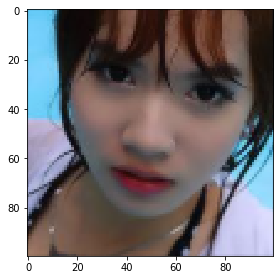

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

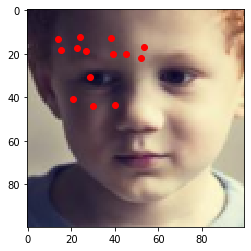

In [3]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(len(points) // 2):
        plt.plot((points[i*2] + 0.5)*100, (points[i*2 + 1] + 0.5)*100, 'o', color='r')
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [4]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

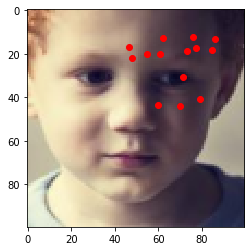

In [5]:
import cv2
def flip_img(img, points):
    # Write your code for flipping here
    f_img = cv2.flip(img, 1)
    f_points = points[:]
    for i in range(len(points) // 2):
        f_points[2*i] *= -1
    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [6]:
# Write your code here
def augmentSample(imgs_train, points_train):
    aug_imgs = []
    aug_points = []
    for img, points in zip(imgs_train, points_train):
        f_img, f_points = flip_img(img, points)
        aug_imgs.append(img)
        aug_imgs.append(f_img)
        aug_points.append(points)
        aug_points.append(f_points)
    return np.asarray(aug_imgs), np.asarray(aug_points)

In [7]:
imgs_train.shape

(5400, 100, 100, 3)

In [8]:
points_train.shape

(5400, 28)

In [9]:
aug_imgs_train, aug_points_train = augmentSample(imgs_train[:1000,:,:,:], points_train[:1000,:])

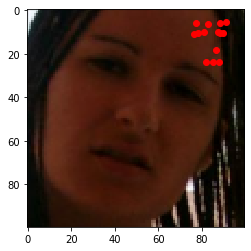

In [14]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

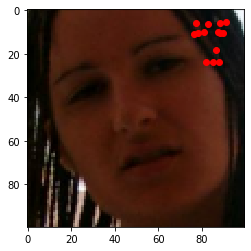

In [11]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [15]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
# Define here your model
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=aug_imgs_train[0].shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(aug_points_train.shape[1], activation='linear'))

Using TensorFlow backend.


Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [16]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss='mse',
              optimizer=Adam(),
              metrics=['mse'])

model.fit(aug_imgs_train, aug_points_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(imgs_val, points_val))

Train on 2000 samples, validate on 600 samples
Epoch 1/10
2000/2000 [==============================] - 103s 51ms/step - loss: 2.6533 - mse: 2.6533 - val_loss: 2.3718 - val_mse: 2.3718
Epoch 2/10
2000/2000 [==============================] - 106s 53ms/step - loss: 1.8912 - mse: 1.8912 - val_loss: 2.4527 - val_mse: 2.4527
Epoch 3/10
2000/2000 [==============================] - 107s 53ms/step - loss: 1.8005 - mse: 1.8005 - val_loss: 2.5382 - val_mse: 2.5382
Epoch 4/10
2000/2000 [==============================] - 109s 54ms/step - loss: 1.7511 - mse: 1.7511 - val_loss: 2.6723 - val_mse: 2.6723
Epoch 5/10
2000/2000 [==============================] - 108s 54ms/step - loss: 1.7051 - mse: 1.7051 - val_loss: 2.6462 - val_mse: 2.6462
Epoch 6/10
2000/2000 [==============================] - 110s 55ms/step - loss: 1.6100 - mse: 1.6100 - val_loss: 2.5558 - val_mse: 2.5558
Epoch 7/10
2000/2000 [==============================] - 111s 56ms/step - loss: 1.4048 - mse: 1.4048 - val_loss: 2.4967 - val_mse: 2

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [17]:
predicted_points = model.predict(imgs_val)
print(predicted_points[0:5, :]) 

[[ 0.1059349  -0.02379434 -0.04188173 -0.07026309 -0.25883618 -0.15538052
  -0.37867087 -0.05270375  0.10243262 -0.0055379   0.03463876 -0.02641284
  -0.04657341 -0.00777664 -0.24332985 -0.02165676 -0.22862653 -0.05834713
  -0.31036755 -0.03420433 -0.11139621  0.12149864 -0.00631564  0.31651595
  -0.13920966  0.26725465 -0.24244255  0.23953952]
 [ 0.00756862  0.09383729 -0.30120626  0.07810988 -0.6689185   0.00619041
  -0.9825158   0.05544215 -0.06077161  0.21482262 -0.1897266   0.17775534
  -0.31569573  0.22416309 -0.6773739   0.18156357 -0.73009974  0.14598127
  -0.9262606   0.14296758 -0.47300723  0.49277142 -0.3005166   0.79681134
  -0.5313497   0.7535822  -0.65379035  0.7223116 ]
 [ 0.1059349  -0.02379434 -0.04188173 -0.07026309 -0.25883618 -0.15538052
  -0.37867087 -0.05270375  0.10243262 -0.0055379   0.03463876 -0.02641284
  -0.04657341 -0.00777664 -0.24332985 -0.02165676 -0.22862653 -0.05834713
  -0.31036755 -0.03420433 -0.11139621  0.12149864 -0.00631564  0.31651595
  -0.13920

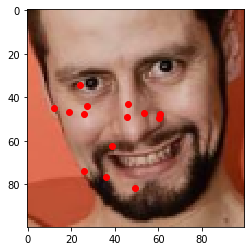

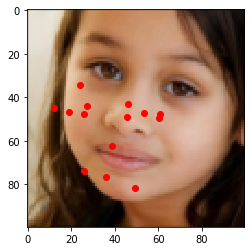

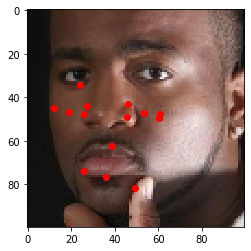

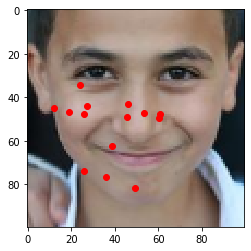

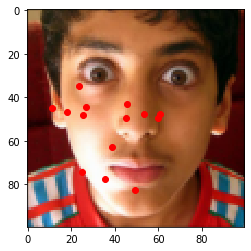

In [40]:
# Example of output
for i in range(5):
    idx = np.random.choice(imgs_val.shape[0])
    visualize_points(imgs_val[idx], predicted_points[idx])